In [1]:
import tempfile
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

from qiime2 import Artifact
from qiime2.plugins.feature_classifier.methods import classify_consensus_vsearch
from qiime2.plugins.feature_table.methods import relative_frequency
from qiime2.plugins.quality_control.visualizers import evaluate_taxonomy

%matplotlib inline

In [2]:
working_dir = os.path.abspath('../')
mocks = ['12', '13', '14', '15', '16', '18', '19', '20', '21', '22']
base_references = ['greengenes', 'silva']
threads = 12

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-mca3rs2t/3884c6a6-032d-4575-9424-864cb4ae0911/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-o8dqa6la/8f619273-1512-4fdb-8cde-4a1500eae8f8/data/dna-sequences.fasta --threads 12 --output_no_hits --blast6out /tmp/tmpu_ociodi

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-mca3rs2t/3884c6a6-032d-4575-9424-864cb4ae0911/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tm

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-gthmln51/2af5ec80-2824-42f8-8ae8-773a5031850f/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-56clwmq6/3221967c-d6bf-4b14-abe4-d85fbed75888/data/dna-sequences.fasta --threads 12 --output_no_hits --blast6out /tmp/tmpaf3cs66e

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-7c1179zh/c21a6c73-ad6d-4e7a-9f82-9e4ecabf06a5/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tm

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-4lj0fk44/8b42318e-6611-41a1-b975-a49d4ab8a29f/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tmp/qiime2-archive-6z0yxpn_/19a3e3c0-f301-4003-b6da-b5fe93eac0f7/data/dna-sequences.fasta --threads 12 --output_no_hits --blast6out /tmp/tmp03i3115e

Running external command line application. This may print messages to stdout and/or stderr.
The command being run is below. This command cannot be manually re-run as it will depend on temporary files that no longer exist.

Command: vsearch --usearch_global /tmp/qiime2-archive-4lj0fk44/8b42318e-6611-41a1-b975-a49d4ab8a29f/data/dna-sequences.fasta --id 0.8 --query_cov 0.8 --strand both --maxaccepts 10 --maxrejects 0 --db /tm

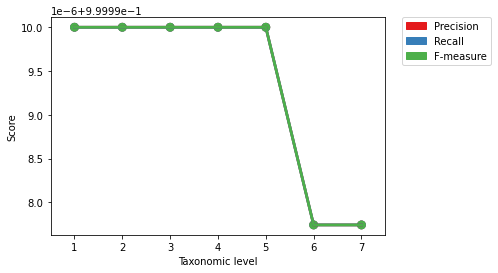

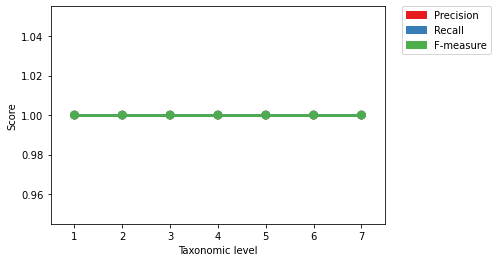

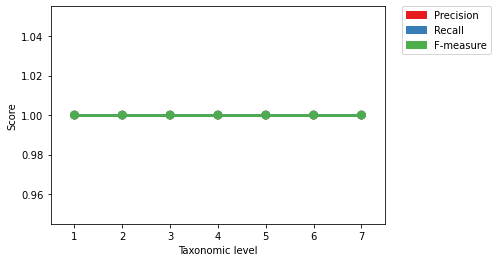

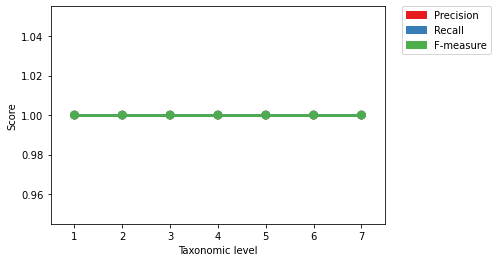

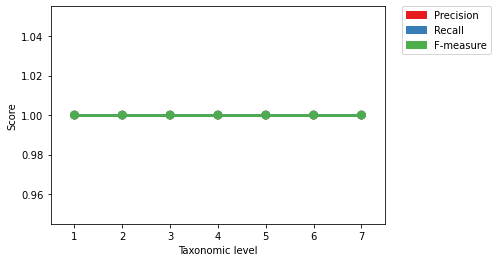

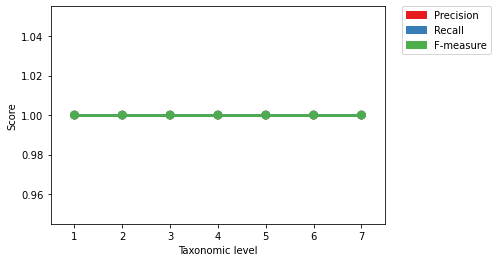

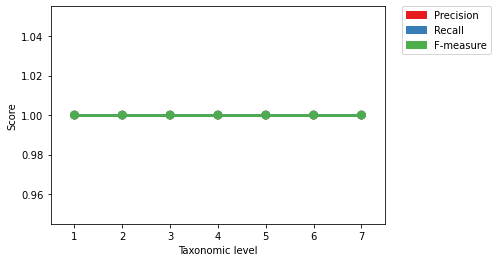

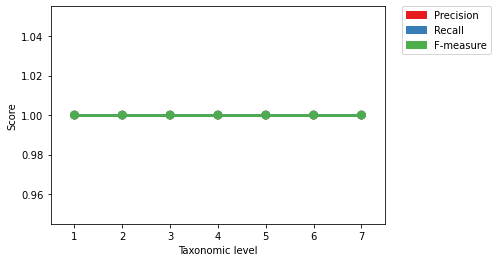

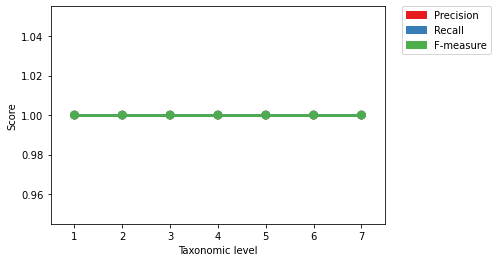

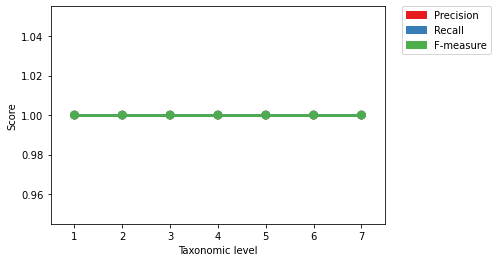

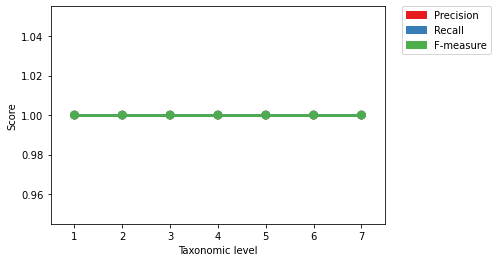

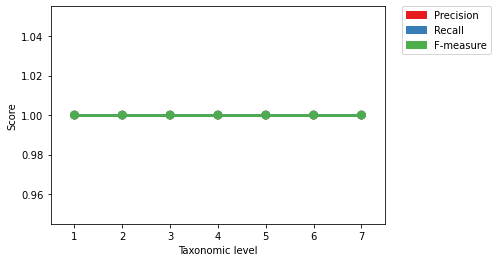

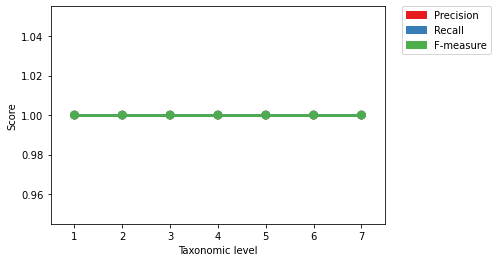

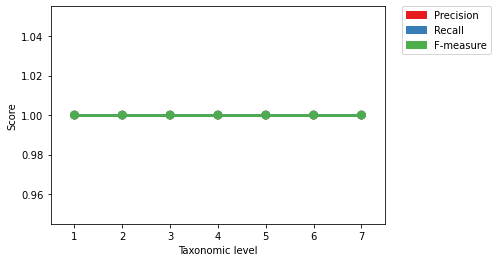

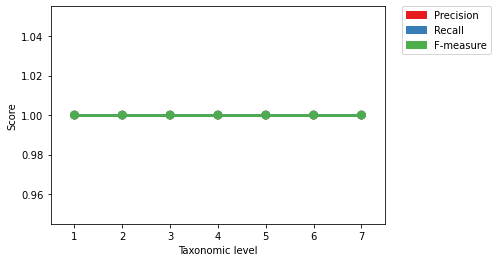

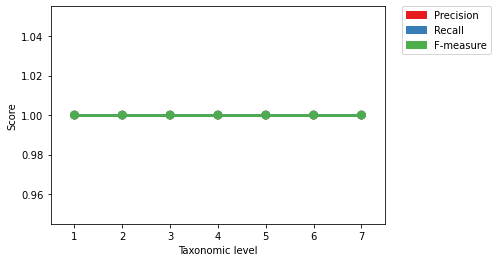

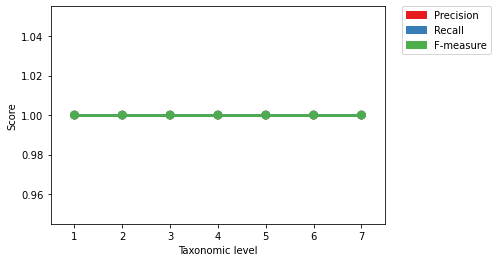

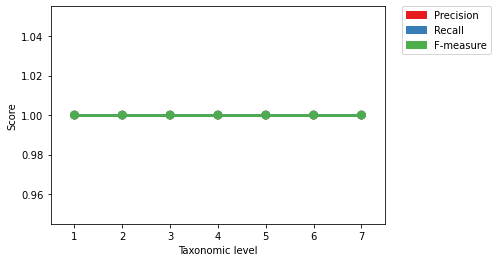

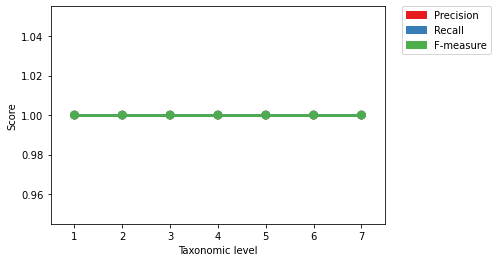

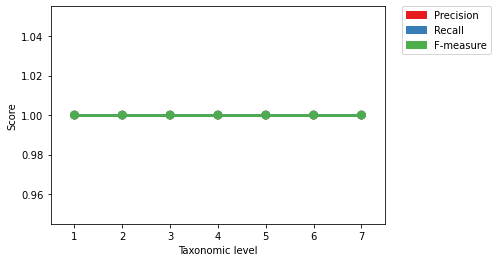

In [3]:
results = pd.DataFrame(columns = ['level', 'Precision', 'Recall', 'F-measure',
                                  'reference_comparison', 'mock'])
for mock in mocks:
    seqs_path = (working_dir + '/output/mock_communities/mock_' + mock + '/mock_' + mock + '_rep_seqs.qza')
    ft_path = (working_dir + '/output/mock_communities/mock_' + mock + '/mock_' + mock + '_ft.qza')
    seq_artifact = Artifact.load(seqs_path)
    ft = Artifact.load(ft_path)
    relative_ft, = relative_frequency(ft)
    for base_reference in base_references:
        base_read_path = (working_dir + '/output/taxonomy_references/' +
                          base_reference + '_otus.qza')
        base_taxonomy_path = (working_dir + '/output/taxonomy_references/' +
                              base_reference + '_taxonomy.qza')
        base_reads = Artifact.load(base_read_path)
        base_taxonomy = Artifact.load(base_taxonomy_path)
        base_classification_taxonomy, = classify_consensus_vsearch(seq_artifact,
                                                                   base_reads,
                                                                   base_taxonomy,
                                                                   threads = threads)
        extended_read_path = (working_dir + '/output/taxonomy_references/' +
                              base_reference + '_metaxa2_otus.qza')
        extended_taxonomy_path = (working_dir + '/output/taxonomy_references/' +
                                  base_reference + '_metaxa2_taxonomy.qza')
        extended_reads = Artifact.load(extended_read_path)
        extended_taxonomy = Artifact.load(extended_taxonomy_path)
        extended_classification_taxonomy, = classify_consensus_vsearch(seq_artifact,
                                                                       extended_reads,
                                                                       extended_taxonomy,
                                                                       threads = threads)
        accuracy_comparison, = evaluate_taxonomy(base_classification_taxonomy,
                                                 extended_classification_taxonomy,
                                                 7, feature_table = relative_ft)
        with tempfile.TemporaryDirectory() as tmpdir:
            accuracy_comparison.export_data(tmpdir)
            df = pd.read_csv(tmpdir + '/results.tsv', '\t', index_col = 0)
        df['reference_comparison'] = base_reference
        df['mock'] = mock
        results = pd.concat([results, df], ignore_index = True)
results.to_csv(working_dir + '/output/accuracy_metrics.csv')

In [4]:
results['mock (base)'] = results['mock'] + ' (' + results['reference_comparison'] + ')'
results['F-measure (relative to base)'] = results['F-measure']

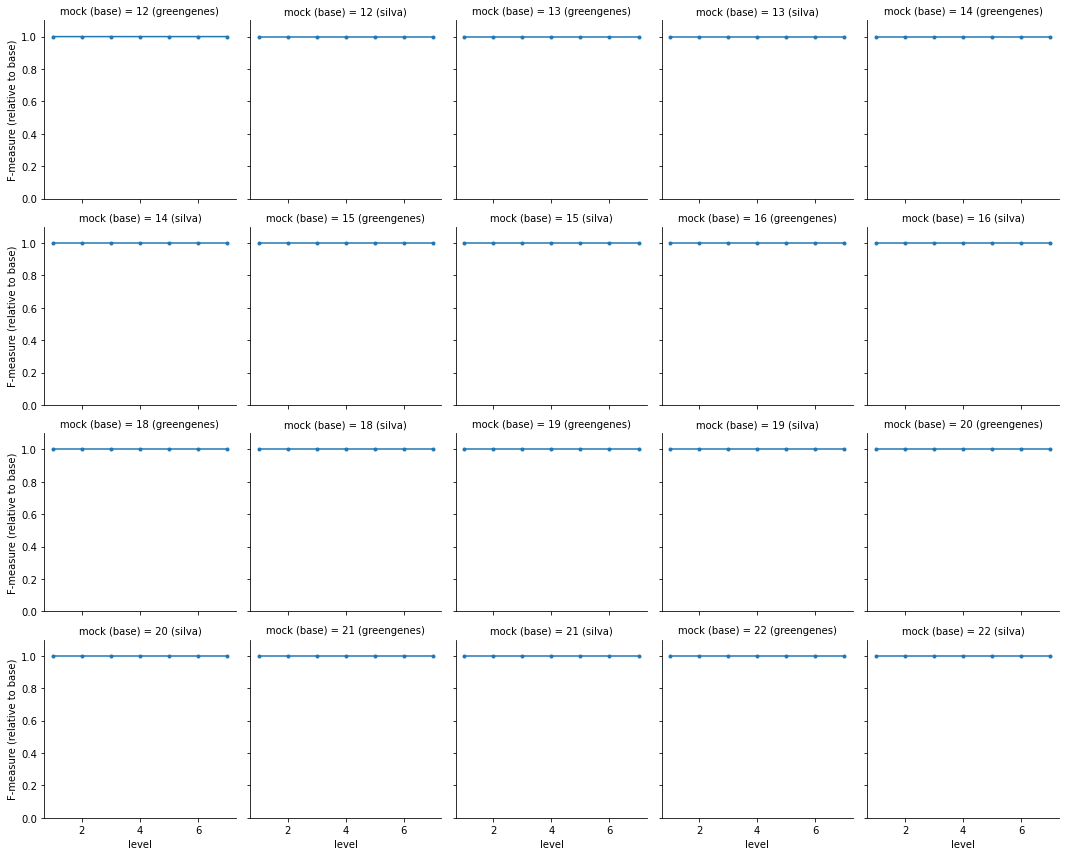

In [5]:
grid = sns.FacetGrid(results, col='mock (base)', col_wrap = 5)
grid.map(plt.plot, 'level', 'F-measure (relative to base)', marker = '.').add_legend()
grid.set(ylim = (0, 1.1))
plt.show()
grid.savefig(working_dir + '/output/accuracy_plots.pdf', dpi=300)